# Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML

if 'google.colab' in str(get_ipython()):
    colab = True
    print('Running on CoLab')
else:
    colab = False
    # enable full width for wide figures
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:100% !important; }</style>"))
    display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
    print('Not running on CoLab')

if colab:
  %matplotlib inline
else:
  %matplotlib notebook

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
if colab == True: mpl.rc('animation', html='jshtml')

import numpy as np
import matplotlib.pyplot as plt
import doctest
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV  
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.pipeline import make_pipeline
import autograd
import autograd.numpy as anp

from scipy.stats import norm # cumulative normal distribution

# enable full width for wide figures
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

Not running on CoLab


# Differential Regression Implementation

In [2]:
def make_polynomial(degree=5):
    return make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(normalize=True))

# ridge regression with builtin cross-validation
def make_ridge(degree=5, alpha=1.0): 
    return make_pipeline(PolynomialFeatures(degree=degree), Ridge(alpha=alpha, normalize=True))

# ridge regression with builtin cross-validation
def make_ridge_cv(degree=5, min_alpha=1e-05, max_alpha=1e02, num_alphas=100): 
    alphas = np.exp(np.linspace(np.log(min_alpha), np.log(max_alpha), num_alphas))
    return make_pipeline(PolynomialFeatures(degree=degree), RidgeCV(alphas=alphas, normalize=True))

class DifferentialRegression:
    
    def __init__(self, degree=5, alpha=1.0):
        self.degree = degree
        self.polynomial_features = PolynomialFeatures(degree=degree, include_bias=True)
        self.alpha = alpha
        self.epsilon = 1.0e-8
    
    def fit(self, x, y, z):     
        self.phi_ = self.polynomial_features.fit_transform(x)
        self.powers_ = self.polynomial_features.powers_
        
        self.dphi_ = self.phi_[:, :, np.newaxis] * self.powers_[np.newaxis, :, :] / (x[:, np.newaxis, :] + self.epsilon)
                
        self.lamj_ = ((y ** 2).mean(axis=0) / (z ** 2).mean(axis=0)).reshape(1,1,-1)
        self.dphiw_ = self.dphi_ * self.lamj_
        
        phiTphi = np.tensordot(self.dphiw_, self.dphi_, axes=([0,2],[0,2]))
        phiTz = np.tensordot(self.dphiw_, z, axes=([0,2],[0,1])).reshape(-1,1)
        
        # note we use np.linalg.pinv (as opposed to np.linalg.inv) to perform safe (SVD) inversion, resilient to near singularities
        inv = np.linalg.pinv(self.phi_.T @ self.phi_ + self.alpha * phiTphi, hermitian=True)
        self.beta_ = (inv @ (self.phi_.T @ y + self.alpha * phiTz)).reshape(-1, 1)
        
    def predict(self, x, predict_derivs=False):
        phi = self.polynomial_features.transform(x)
        y_pred = phi @ self.beta_
        
        if predict_derivs:
            dphi = phi[:, :, np.newaxis] * self.powers_[np.newaxis, :, :] / (x[:, np.newaxis, :] + self.epsilon)
            z_pred = np.tensordot(dphi, self.beta_, (1, 0)).reshape(dphi.shape[0], -1)
            return y_pred, z_pred
        else:
            return y_pred

# Differential Regression on Heston Dataset

1. In this notebook we verify the performance of the differential regression algorithm under a more complex stochastic model. 
2. For this purpose we implement the well-known stochastic volatility model of Heston (1993) and perform the same analysis as in the Black-Scholes case. 
3. The implementation of the analytical pricing and delta formulas is based on *R. Crisostomo (2014): An Analysis of the Heston Stochastic Volatility Model.*
4. Automatic differentiation is done using the *autograd* package and a custom trapezoid implementation for numerical integration.
5. To simulate price paths we apply the truncated (Log)Euler scheme as stated in: *A. van Haastrecht and A. Pelsser (2008) - Efficient, almost exact simulation of the Heston stochastic volatility model*

In [3]:
class HestonCall:
    """
    General purpose class representing a European call option under the Heston (1993) model.
    Calculation of the semi-analytical formulas follows the approach of Crisostomo (2014).
    """

    def __init__(self, r: float, kappa: float, theta: float, eta: float, rho: float, feller: bool = False) -> None:
        """
        (1) r     : Constant short rate.
        (2) kappa : Speed of variance mean-reversion.
        (3) theta : Long-run average variance.
        (4) eta   : Volatility of volatility.
        (5) rho   : Correlation of Wiener processes.
        """
        self.r = r
        self.kappa = kappa
        self.theta = theta
        self.eta = eta
        self.rho = rho
        self._check_feller_condition(feller)
        self.dx_grid = anp.linspace(1e-8, 100.0, num=1000)

    def price(self, S0: float, v0: float, K: float, tau: float) -> float:
        """
        No arbitrage price of the option.
        (1) S0:  Current spot price.
        (2) v0:  Current spot price volatility.
        (3) K:   Strike price.
        (4) tau: Time to maturity.
        """
        pi_1 = self._pi_1(S0, v0, K, tau)
        pi_2 = self._pi_2(S0, v0, K, tau)
        return S0 * pi_1 - anp.exp(-self.r * tau) * K * pi_2

    def delta(self, S0: float, v0: float, K: float, tau: float, method: str = "cf") -> float:
        """
        Sensitivity of the option price with regards to the underlying spot price.
        """
        if method == "cf":
            return self._delta_cf(S0, v0, K, tau)
        elif method == "ad":
            return self._delta_ad(S0, v0, K, tau)
        else:
            raise ValueError(f"Delta calculation method {method} is unsupported!")

    def _delta_ad(self, S0: float, v0: float, K: float, tau: float) -> float:
        """
        Numerical delta is calculated using Automatic Differentiation (AD).
        """
        def price(x: float) -> float:
            return self.price(x, v0, K, tau)
        delta_grad = autograd.grad(price)
        return delta_grad(S0)

    def _delta_cf(self, S0: float, v0: float, K: float, tau: float) -> float:
        """
        Analytical delta is calculated by taking the first derivative of the price w.r.t. S0.
        """
        return self._pi_1(S0, v0, K, tau)

    def _pi_2(self, S0: float, v0: float, K: float, tau: float) -> float:
        """
        This quantity doubles as the probability of exercise under the risk neutral measure.
        """
        integrand_2 = self._integrand_2(S0, v0, K, tau)
        y = integrand_2(self.dx_grid)
        integral_2 = self._trapz(y, self.dx_grid)
        return 0.5 + (1.0 / anp.pi) * integral_2

    def _integrand_2(self, S0: float, v0: float, K: float, tau: float):
        """
        The integrand for the integral contained in the Pi_{2} expression.
        Returns a lambda function that can be easily integrated using SciPy.
        """

        def fn_1(w: anp.array) -> anp.array:
            return anp.exp(-1j * w * anp.log(K))

        def fn_2(w: anp.array) -> anp.array:
            return self._characteristic_function(S0, v0, tau, w)

        def fn_3(w: anp.array) -> anp.array:
            return 1j * w

        return lambda w: anp.real((fn_1(w) * fn_2(w) / fn_3(w)))

    def _pi_1(self, S0: float, v0: float, K: float, tau: float) -> float:
        """
        This quantity doubles as the call option delta.
        """

        integrand_1 = self._integrand_1(S0, v0, K, tau)
        y = integrand_1(self.dx_grid)
        integral_1 = self._trapz(y, self.dx_grid)
        return 0.5 + (1.0 / anp.pi) * integral_1

    def _trapz(self, y: anp.array, x: anp.array) -> float:
        """
        Performs numerical integration by summing trapezoids.
        Autograd package does not have a working implementation of np.trapz.
        """
        dx = anp.diff(x)
        return anp.sum((y[0:-1] + y[1:]) * dx / 2)

    def _integrand_1(self, S0: float, v0: float, K: float, tau: float):
        """
        The integrand for the integral contained in the Pi_{1} expression.
        Returns a lambda expression that can be easily integrated using SciPy.
        """

        def fn_1(w: anp.array) -> anp.array:
            return anp.exp(-1j * w * anp.log(K))

        def fn_2(w: anp.array) -> anp.array:
            return self._characteristic_function(S0, v0, tau, w - 1j)

        def fn_3(w: anp.array) -> anp.array:
            return 1j * w * self._characteristic_function(S0, v0, tau, -1j)

        return lambda w: anp.real((fn_1(w) * fn_2(w) / fn_3(w)))

    def _check_feller_condition(self, check_feller: bool) -> None:
        """
        Check whether the variance remains strictly positive.
        """
        if check_feller:
            assert 2.0 * self.kappa * self.theta >= anp.square(self.eta)

    def _characteristic_function(self, S0: float, v0: float, tau: float, w: anp.array) -> anp.array:
        """
        Evaluates the characteristic function of log(St) under the Heston model.
        """
        # (1) Intermediate calculations.
        alpha = -(anp.square(w) / 2.0) - (w / 2.0) * 1j
        beta = self.kappa - self.rho * self.eta * 1j * w
        gamma = anp.square(self.eta) / 2.0
        h = anp.sqrt(anp.square(beta) - 4.0 * alpha * gamma)
        r_plus = (beta + h) / anp.square(self.eta)
        r_minus = (beta - h) / anp.square(self.eta)
        g = r_minus / r_plus
        # (2) Characteristic function inputs.
        c = self.kappa * (r_minus * tau - (2.0 / anp.square(self.eta)) * anp.log((1.0 - g * anp.exp(-h * tau)) / (1.0 - g)))
        d = r_minus * (1.0 - anp.exp(-h * tau) / (1.0 - g * anp.exp(-h * tau)))
        # (3) Characteristic function values at w.
        return anp.exp(c * self.theta + d * v0 + 1j * w * anp.log(S0 * anp.exp(self.r * tau)))

In [4]:
class HestonCallTester:
    """
    Tests the HestonCall class (including AD) against some validation outputs in Crisostomo (2014).
    """
    
    def __init__(self) -> None:
        self.r = 0.00
        self.kappa = 1.0
        self.theta = 0.16
        self.eta = 2.00
        self.rho = -0.80
        self.feller = False
        self.S0 = 1.00
        self.K = 2.00
        self.v0 = 0.16
        self.tau = 10.00
        self.abs_tol = 1e-4
        self.target_price = 0.0495
        self.target_delta = 0.2558
        
    def run(self) -> None:
        call = HestonCall(r=self.r, kappa=self.kappa, theta=self.theta, eta=self.eta, rho=self.rho, feller=self.feller)
        self._price_test(call)
        self._delta_test(call)
        print("All HestonCall tests are passed!")
    
    def _price_test(self, call) -> None:
        calculated_price = call.price(S0=self.S0, v0=self.v0, K=self.K, tau=self.tau)
        assert np.abs(calculated_price-self.target_price) < self.abs_tol
        
    def _delta_test(self, call) -> None:
        calculated_delta = call.delta(S0=self.S0, v0=self.v0, K=self.K, tau=self.tau, method="cf")
        assert np.abs(calculated_delta-self.target_delta) < self.abs_tol
        
    def _delta_ad_test(self, call) -> None:
        cf_delta = call.delta(S0=self.S0, v0=self.v0, K=self.K, tau=self.tau, method="cf")
        ad_delta = call.delta(S0=self.S0, v0=self.v0, K=self.K, tau=self.tau, method="ad")
        assert np.abs(cf_delta-ad_delta) < self.abs_tol
        
        
HestonCallTester().run()

All HestonCall tests are passed!


In [5]:
class HestonSimulator:
    """
    A simulator for the spot price dynamics under the Heston (1993) model.
    Calculation of the spot price paths follows the truncated (Log)Euler scheme in van Haastrecht (2008).
    """

    def __init__(self, r: float, kappa: float, theta: float, eta: float, rho: float, feller: bool = True) -> None:
        """
        (1) r     : Constant short rate.
        (2) kappa : Speed of variance mean-reversion.
        (3) theta : Long-run average variance.
        (4) eta   : Volatility of volatility.
        (5) rho   : Correlation of Wiener processes.
        """
        self.r = r
        self.kappa = kappa
        self.theta = theta
        self.eta = eta
        self.rho = rho
        self._check_feller_condition(feller)

    def paths(self, m: int, tau: float, dt: float, S0_min: float, S0_max: float, v0: float) -> tuple:
        """
        Generates m spot price paths under the Heston (1993) model.
        We keep the starting value of the variance (v0) process fixed.
        (1) m: Number of paths.
        (2) tau: Time to maturity.
        (3) dt: Step size.
        """
        # (1) Draw Gaussian variables (for Wiener increments).
        n = int(tau // dt) + 1
        Z1, Z2 = tuple([np.random.normal(0.0, 1.0, size=(m, n)) for _ in range(2)])
        Zs, Zv = self.rho * Z1 + np.sqrt(1.0-np.square(self.rho)) * Z2, Z1
        # (2) Initialize (log) spot price matrix.
        logS = np.ones((m, n)) * np.nan
        logS[:, [0]] = np.log(np.linspace(S0_min, S0_max, m).reshape(-1, 1))
        # (3) Initialize spot price variance matrix.
        v = np.ones((m, n)) * np.nan
        v[:, [0]] = np.ones((m, 1)) * v0
        # (4) Fill path matrices using loop.
        dt_sqrt = np.sqrt(dt)
        for k in range(1, n):
            # (4.1) Given v(s) compute v(t).
            vs = v[:, [k-1]]
            vs_plus = np.maximum(vs, 0.0)
            v[:, [k]] = vs + self.kappa * dt * (self.theta-vs_plus) + self.eta * np.sqrt(vs_plus) * Zv[:, [k]] * dt_sqrt
            # (4.2) Given log[S(s)] compute log[S(t)].
            logSs = logS[:, [k-1]]
            logS[:, [k]] = logSs + (self.r - 0.50*vs_plus) * dt + np.sqrt(vs_plus) * Zs[:, [k]] * dt_sqrt
        return np.exp(logS), v

    def _check_feller_condition(self, check_feller: bool) -> None:
        """
        Check whether the variance remains strictly positive.
        """
        if check_feller:
            assert 2.0 * self.kappa * self.theta >= np.square(self.eta)

In [6]:
class HestonSimulatorTester:
    """
    Tests the HestonSimulator class via MC simulation.
    Parameters used correspond to Case I / Call-10Y / Table 2 in van Haastrecht (2008).
    """
    def __init__(self) -> None:
        self.r = 0.00
        self.kappa = 0.50
        self.theta = 0.04
        self.eta = 1.00
        self.rho = -0.90
        self.feller = False
        self.S0 = 100.0
        self.K = 100.0
        self.v0 = 0.04
        self.tau = 10.00
        self.dt = 1/32
        self.n_paths = 50000
        # Tolerance is roughly based on Monte Carlo errors in the paper.
        self.abs_tol = 0.05

    def run(self) -> None:
        call = HestonCall(r=self.r, kappa=self.kappa, theta=self.theta, eta=self.eta, rho=self.rho, feller=self.feller)
        simulator = HestonSimulator(r=self.r, kappa=self.kappa, theta=self.theta, eta=self.eta, rho=self.rho, feller=self.feller)
        self._martingale_test(simulator)
        self._call_test(simulator, call)
        print("All HestonSimulator tests are passed!")

    def _call_test(self, simulator: HestonSimulator, call: HestonCall) -> None:
        payoff_fn = lambda x: np.maximum(x - self.K, 0.0)
        price_mc = self._price_mc(payoff_fn, simulator)
        price_cf = call.price(self.S0, self.v0, self.K, self.tau)
        assert np.abs(price_mc/price_cf-1.0) < self.abs_tol

    def _martingale_test(self, simulator: HestonSimulator) -> None:
        payoff_fn = lambda x: x
        S0_mc = self._price_mc(payoff_fn, simulator)
        assert np.abs(self.S0/S0_mc-1.0) < self.abs_tol

    def _price_mc(self, payoff_fn, simulator: HestonSimulator) -> float:
        S, _ = simulator.paths(self.n_paths, self.tau, self.dt, self.S0, self.S0, self.v0)
        return np.exp(-self.r * self.tau) * np.mean(payoff_fn(S[:, [-1]]))
    
HestonSimulatorTester().run()

All HestonSimulator tests are passed!


In [7]:
class HestonProvider:
    """
    Provides the Heston data sets used for differential regression.
    """

    def __init__(self, r: float, kappa: float, theta: float, eta: float, rho: float, feller: bool = True) -> None:
        self.call = HestonCall(r=r, kappa=kappa, theta=theta, eta=eta, rho=rho, feller=feller)
        self.simulator = HestonSimulator(r=r, kappa=kappa, theta=theta, eta=eta, rho=rho, feller=feller)

    def train_set(self, m: int, tau: float, dt: float, S0_min: float, S0_max: float, v0: float, K: float, delta_method: str) -> tuple:
        S, v = self.simulator.paths(m, tau, dt, S0_min, S0_max, v0)
        S0, ST = S[:, 0], S[:, -1]
        dcf = np.exp(-self.call.r * tau) * np.maximum(ST - K, 0.0)
        # ------------- Todo: This should ideally be vectorized. ------------------------
        delta = np.array([self.call.delta(S0[k], v0, K, tau) for k in range(S0.shape[0])])
        # -------------------------------------------------------------------------------
        return S0.reshape(-1, 1), dcf.reshape(-1, 1), delta.reshape(-1, 1)

    def test_set(self, m: int, tau: float, S0_min: float, S0_max: float, v0: float, K: float, delta_method: str) -> tuple:
        S0 = np.linspace(S0_min, S0_max, m).reshape(-1, 1)
        # ------------- Todo: This should ideally be vectorized. ------------------------
        price = np.array([self.call.price(S0[k], v0, K, tau) for k in range(S0.shape[0])])
        delta = np.array([self.call.delta(S0[k], v0, K, tau) for k in range(S0.shape[0])])
        # -------------------------------------------------------------------------------
        return S0.reshape(-1, 1), price.reshape(-1, 1), delta.reshape(-1, 1)

In [8]:
"""
In this cell we define the parameters and constants.
"""
# (1) Heston model parameters.
r = 0.00
kappa = 1.00
theta = 0.16
eta = 2.00
rho = -0.80
feller = False
# (2) Call and simulation parameters.
m_train, m_test = 200, 5000
tau, dt = 2.0, 0.01
S0_min_train, S0_max_train = 50.0, 200.0
S0_min_test, S0_max_test = 10.0, 250.0
v0 = 0.16
K = 110.0
delta_method = "ad" 

In [9]:
"""
In this cell we generate the Heston dataset.
Contrary to the Black-Scholes notebook we extend the test set beyond the training domain.
"""
provider = HestonProvider(r, kappa, theta, eta, rho, feller)
x_train, y_train, z_train = provider.train_set(m_train, tau, dt, S0_min_train, S0_max_train, v0, K, delta_method)
x_test, y_test, z_test = provider.test_set(m_test, tau, S0_min_test, S0_max_test, v0, K, delta_method)

In [10]:
"""
In this cell we train the regression models and generate predictions
"""
linreg = make_polynomial()
linreg.fit(x_train, y_train)
linpred = linreg.predict(x_test)

ridgereg = make_ridge_cv()
ridgereg.fit(x_train, y_train)
ridgepred = ridgereg.predict(x_test)
alpha = ridgereg['ridgecv'].alpha_

diffreg = DifferentialRegression()
diffreg.fit(x_train, y_train, z_train)
diffpred = diffreg.predict(x_test)

# Plot Results

Ridge regression alpha = 0.2420


<IPython.core.display.Javascript object>


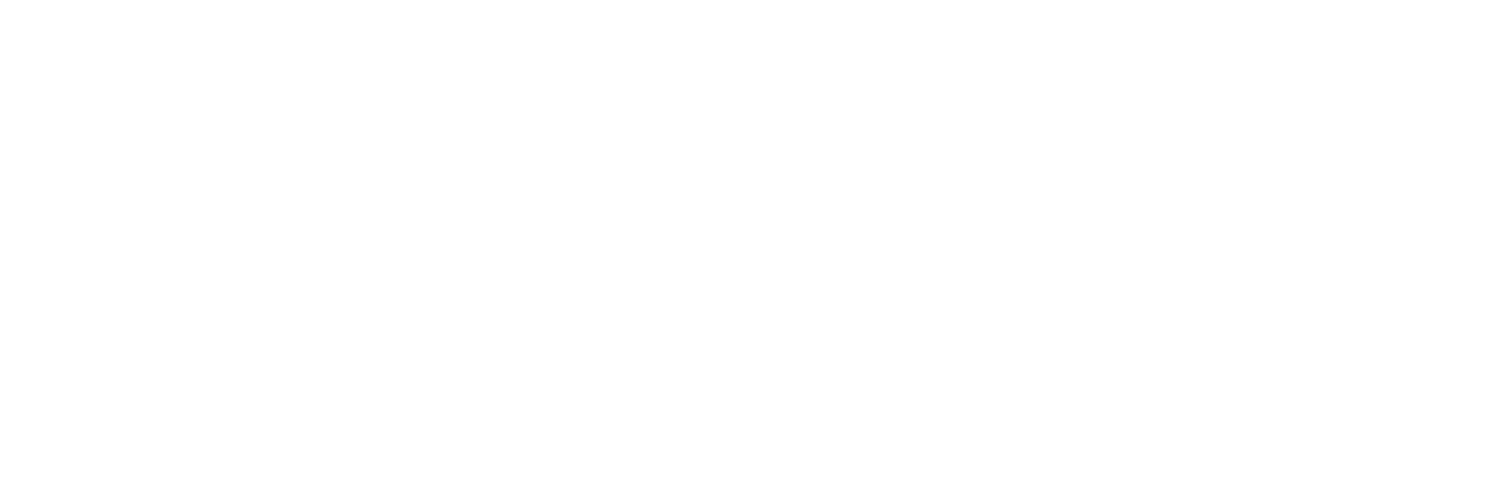

In [11]:
"""
In this cell we plot the differential regression results.
"""

def plot_one(ax, x_train, y_train, x_test, y_test, pred):
    samples, = ax.plot(x_train, y_train, 'co', markersize=5, markerfacecolor="white", label="samples")
    predict, = ax.plot(x_test, pred, 'b-', label="predict")
    correct, = ax.plot(x_test, y_test, 'r-', label="correct")
    train_min = ax.axvline(x=S0_min_train, ymin=0.00, ymax=1.00, color='black', ls=':', label="train_domain")
    train_max = ax.axvline(x=S0_max_train, ymin=0.00, ymax=1.00, color='black', ls=':')
    return samples, predict, correct, train_min, train_max

def plot_multi(x_train, y_train, x_test, y_test, titles, preds):
    nplots = len(preds)
    nrows = (nplots - 1) // 3 + 1
    ncols = min(nplots, 3)
    
    fig, axs = plt.subplots(nrows, ncols, squeeze=False)
    fig.set_size_inches(ncols * 5, nrows * 5)
    fig.suptitle("Differential Regression: Heston Call")

    lines = []
    for i, ax in enumerate(axs.flatten()):
        if i < nplots:
            samples, predict, correct, train_min, train_max = plot_one(ax, x_train, y_train, x_test, y_test, preds[i])
            lines.extend([samples, predict, correct])
            ax.legend(loc=2)
            ax.set_title(titles[i])
    
    return fig, lines
            
print("Ridge regression alpha = %.4f" % alpha)
fig, lines = plot_multi(x_train, y_train, x_test, y_test, ["linear regression", "ridge regression", "differential regression"], [linpred, ridgepred, diffpred])

<IPython.core.display.Javascript object>


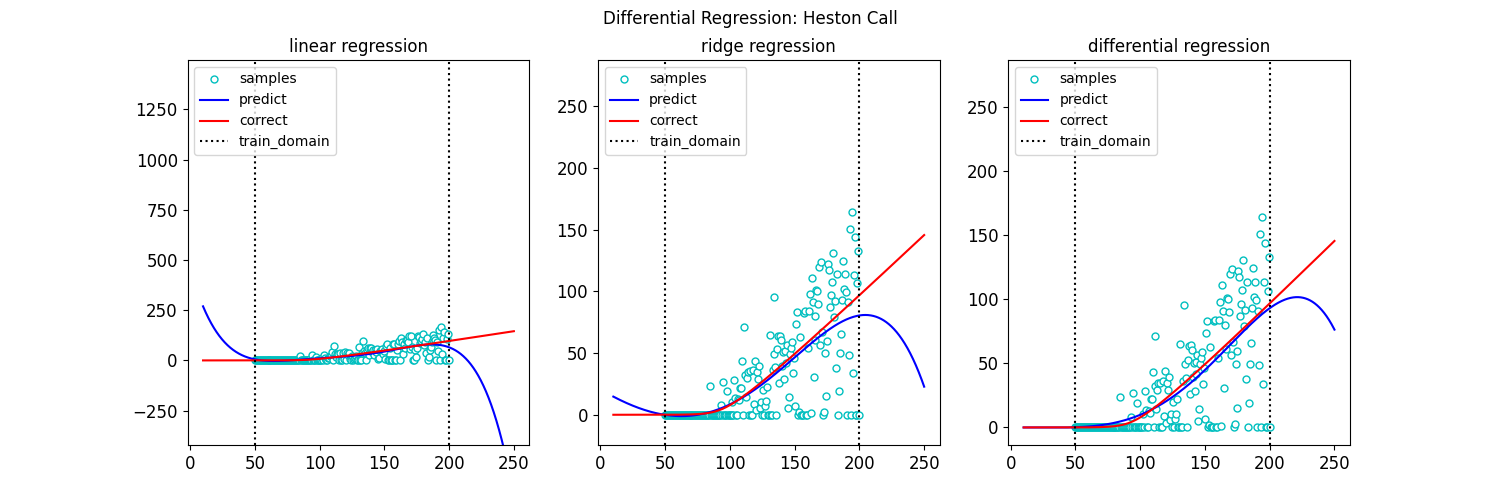

In [12]:
"""
In this cell we animate the differential regression plots.
"""

if colab:
    def init():
      fig, lines = plot_multi(x_train, y_train, x_test, y_test, 
           ["linear regression", "ridge regression", "differential regression"],
           [linpred, ridgepred, diffpred])
      plt.close(fig)
      return lines
else:
    fig, lines = plot_multi(x_train, y_train, x_test, y_test, 
       ["linear regression", "ridge regression", "differential regression"],
       [linpred, ridgepred, diffpred])

def animate(i):
    seed = np.random.randint(8192)
    x_train, y_train, z_train = provider.train_set(m_train, tau, dt, S0_min_train, S0_max_train, v0, K, delta_method)
    
    linreg.fit(x_train, y_train)
    linpred = linreg.predict(x_test)
    ridgereg.fit(x_train, y_train)
    ridgepred = ridgereg.predict(x_test)
    diffreg.fit(x_train, y_train, z_train)
    diffpred = diffreg.predict(x_test)
    
    lines[0].set_data(x_train, y_train)
    lines[1].set_data(x_test, linpred)
    lines[3].set_data(x_train, y_train)
    lines[4].set_data(x_test, ridgepred)
    lines[6].set_data(x_train, y_train)
    lines[7].set_data(x_test, diffpred)
    
    return lines

FuncAnimation(fig, animate, init_func=init if colab else None, frames=20 if colab else 200, interval=500, blit=True, repeat_delay=100)

# Conclusion

If the train and test domains are the same, we draw similar conclusions to the Black-Scholes case.

1. Linear regression appears to overfit substantially, especially for strongly OTM / ITM calls.
2. L2 regularization appears ineffective to remedy this problem, this clearly seen for ITM calls (weird humps).
3. Differential regression appears robust and approximately finds the correct shape, given the low sample size.
4. Differential regression appears to have some trouble capturing the region $S_{0} \in [60, 120]$.

Extending the test domain beyond the train domain reveals some unsettling results.

1. All methods perform very poorly out-of-domain for deep ITM calls.
2. Linear and ridge regression also perform very poorly out-of-domain for OTM calls.
3. Differential regression appears to capture the (approximately) zero price of deep OTM calls.
4. It is surprising that all methods struggle to learn an apparently near-linear function for deep ITM calls.
4. Increasing the test sample size does not appear to alleviate these concerns
5. The results indicate that practical implementation of these methods is dangerous without carefully considering the training domain.